In [178]:
from openaq import OpenAQ
import pandas as pd
from datetime import datetime

client = OpenAQ(api_key='e6b162759d6b804ebcb8e855fe46395c13d93c032dc5c5f22f551a530ee09cfe')

In [179]:
# Lấy các trạm đo trên cả nước
country_id = 56
sensor_data_list = []

country = client.locations.list(countries_id=country_id)

if country.results:
    for location in country.results:
        for sensor in location.sensors:
            sensor_data_list.append({
                "Location Name": location.name,
                "Country": location.country.name,
                "Timezone": location.timezone,
                "Sensor ID": sensor.id,
                "Sensor Name": sensor.name,
                "Parameter": sensor.parameter.name,
                "Units": sensor.parameter.units
            })

df_sensors = pd.DataFrame(sensor_data_list)

print(df_sensors.head())

                          Location Name  Country          Timezone  Sensor ID  \
0          SPARTAN - Vietnam Acad. Sci.  Vietnam      Asia/Bangkok         37   
1  US Diplomatic Post: Ho Chi Minh City  Vietnam  Asia/Ho_Chi_Minh       4681   
2             US Diplomatic Post: Hanoi  Vietnam      Asia/Bangkok       5049   
3  US Diplomatic Post: Ho Chi Minh City  Vietnam  Asia/Ho_Chi_Minh      21631   
4                                 Hanoi  Vietnam      Asia/Bangkok      21632   

  Sensor Name Parameter  Units  
0  pm25 µg/m³      pm25  µg/m³  
1  pm25 µg/m³      pm25  µg/m³  
2  pm25 µg/m³      pm25  µg/m³  
3  pm25 µg/m³      pm25  µg/m³  
4  pm25 µg/m³      pm25  µg/m³  


In [180]:
# Lấy các thuộc tính các trạm đo (2 trạm ở HN)
locations = [2161296, 2161306]

sensors_data = []
existing_parameters = set()

for location_id in locations:
    location = client.locations.get(location_id)

    if location.results:
        for sensor in location.results[0].sensors:
            param_name = sensor.parameter.name

            if param_name not in existing_parameters:
                sensor_info = {
                    "Label": sensor.parameter.name,
                    "Id": sensor.id
                }
                sensors_data.append(sensor_info)
                existing_parameters.add(param_name)
            else:
                print(f"Parameter {param_name} already exists.")
    else:
        print(f"No data found for location ID {location_id}.")

print(sensors_data)

Parameter co already exists.
Parameter no2 already exists.
Parameter pm10 already exists.
Parameter pm25 already exists.
[{'Label': 'co', 'Id': 7771983}, {'Label': 'no2', 'Id': 7772030}, {'Label': 'pm10', 'Id': 7772101}, {'Label': 'pm25', 'Id': 7772040}, {'Label': 'o3', 'Id': 7772097}, {'Label': 'so2', 'Id': 7772047}]


In [181]:
# Lấy dữ liệu đo lường từ API sensors
data_list = []

data = 'measurements'
rollup = 'hourly'
datetime_from = '2025-01-01'
datetime_to = '2025-02-01'

for sensor in sensors_data:
    sensors_id = sensor["Id"]
    measurements_response = client.measurements.list(
        sensors_id=sensors_id,
        data=data,
        rollup=rollup,
        datetime_from=datetime_from,
        datetime_to=datetime_to
    )

    if measurements_response.results:
        for result in measurements_response.results:
            date_utc = datetime.strptime(result.period.datetime_from.utc, "%Y-%m-%dT%H:%M:%SZ")
            formatted_date = date_utc.strftime("%Y-%m-%d %H:%M:%S")

            data_list.append({
                "Date UTC": formatted_date,
                "Parameter": f"{result.parameter.name} ({result.parameter.units})",
                "Value": result.value
            })

# Tạo bảng các giá trị
df = pd.DataFrame(data_list)
df_pivot = df.pivot_table(index="Date UTC",
                          columns="Parameter",
                          values="Value",
                          aggfunc="first").reset_index()
df_pivot.columns.name = None

# Đồng bộ cột Index để merge
df_pivot["Date UTC"] = pd.to_datetime(df_pivot["Date UTC"])

# In bảng
print(df_pivot.head())

             Date UTC  co (µg/m³)  no2 (µg/m³)  o3 (µg/m³)  pm10 (µg/m³)  \
0 2024-12-31 17:00:00      2180.0        113.0         NaN         116.0   
1 2024-12-31 21:00:00      1820.0         89.6         NaN         120.0   
2 2024-12-31 23:00:00      1840.0         84.6         NaN         140.0   
3 2025-01-01 00:00:00      1720.0         89.3         NaN         139.0   
4 2025-01-01 01:00:00      1390.0         92.6         NaN         129.0   

   pm25 (µg/m³)  so2 (µg/m³)  
0          81.2          NaN  
1          84.0          NaN  
2          97.8          NaN  
3          97.4          NaN  
4          98.2          NaN  


In [182]:
sensors_id = 7772040
measurements_response = client.measurements.list(
    sensors_id=sensors_id,
    data=data,
    rollup=rollup,
    datetime_from=datetime_from,
    datetime_to=datetime_to
)

if measurements_response.results:
    for result in measurements_response.results:
        date_utc = datetime.strptime(result.period.datetime_from.utc, "%Y-%m-%dT%H:%M:%SZ")
        formatted_date = date_utc.strftime("%Y-%m-%d %H:%M:%S")

        print("Date UTC: ", formatted_date)
        print("Parameter: ", result.parameter.name, " (", result.parameter.units, ")")
        print("Value: ", result.value)

Date UTC:  2024-12-31 17:00:00
Parameter:  pm25  ( µg/m³ )
Value:  81.2
Date UTC:  2024-12-31 21:00:00
Parameter:  pm25  ( µg/m³ )
Value:  84.0
Date UTC:  2024-12-31 23:00:00
Parameter:  pm25  ( µg/m³ )
Value:  97.8
Date UTC:  2025-01-01 00:00:00
Parameter:  pm25  ( µg/m³ )
Value:  97.4
Date UTC:  2025-01-01 01:00:00
Parameter:  pm25  ( µg/m³ )
Value:  98.2
Date UTC:  2025-01-01 02:00:00
Parameter:  pm25  ( µg/m³ )
Value:  97.2
Date UTC:  2025-01-01 03:00:00
Parameter:  pm25  ( µg/m³ )
Value:  84.5
Date UTC:  2025-01-01 04:00:00
Parameter:  pm25  ( µg/m³ )
Value:  68.5
Date UTC:  2025-01-01 05:00:00
Parameter:  pm25  ( µg/m³ )
Value:  60.6
Date UTC:  2025-01-01 06:00:00
Parameter:  pm25  ( µg/m³ )
Value:  63.5
Date UTC:  2025-01-01 07:00:00
Parameter:  pm25  ( µg/m³ )
Value:  53.5
Date UTC:  2025-01-01 08:00:00
Parameter:  pm25  ( µg/m³ )
Value:  45.3
Date UTC:  2025-01-01 09:00:00
Parameter:  pm25  ( µg/m³ )
Value:  41.4
Date UTC:  2025-01-01 10:00:00
Parameter:  pm25  ( µg/m³ )
Value

In [186]:
# Lấy dữ liệu thời tiết từ Meteostat
from meteostat import Hourly, Point

hanoi = Point(21.0285, 105.8542)

start = pd.Timestamp(datetime(2025, 1, 1))
end = pd.Timestamp(datetime(2025, 2, 1))

weather_data = Hourly(hanoi, start, end).fetch()

# Đồng bộ cột Index để merge
weather_data = weather_data.reset_index()
weather_data.rename(columns={"time": "Date UTC"}, inplace=True)

# In kết quả
print(weather_data.head())

             Date UTC  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
0 2025-01-01 00:00:00  12.0  11.1  94.0   0.0   NaN    0.0   0.0   NaN   
1 2025-01-01 01:00:00  14.0  13.0  94.0   0.0   NaN  100.0   5.4   NaN   
2 2025-01-01 02:00:00  17.0  12.9  77.0   0.0   NaN   80.0   5.4   NaN   
3 2025-01-01 03:00:00  19.0  12.0  64.0   0.0   NaN   80.0   7.6   NaN   
4 2025-01-01 04:00:00  21.0  12.9  60.0   0.0   NaN   90.0   7.6   NaN   

     pres  tsun  coco  
0  1019.0   NaN   5.0  
1  1020.0   NaN   5.0  
2  1020.0   NaN   5.0  
3  1020.0   NaN   5.0  
4  1019.0   NaN   5.0  


In [187]:
# Merge 2 table theo cột Index: "Date UTC"
merged_df = pd.merge(df_pivot, weather_data, on="Date UTC", how="outer")

# In kết quả
print(merged_df.head())

# Xuất kết quả ra file CSV
merged_df.to_csv("data/fetch.csv", index=False, encoding="utf-8")

             Date UTC  co (µg/m³)  no2 (µg/m³)  o3 (µg/m³)  pm10 (µg/m³)  \
0 2024-12-31 17:00:00      2180.0        113.0         NaN         116.0   
1 2024-12-31 21:00:00      1820.0         89.6         NaN         120.0   
2 2024-12-31 23:00:00      1840.0         84.6         NaN         140.0   
3 2025-01-01 00:00:00      1720.0         89.3         NaN         139.0   
4 2025-01-01 01:00:00      1390.0         92.6         NaN         129.0   

   pm25 (µg/m³)  so2 (µg/m³)  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
0          81.2          NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   
1          84.0          NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   
2          97.8          NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   
3          97.4          NaN  12.0  11.1  94.0   0.0   NaN    0.0   0.0   NaN   
4          98.2          NaN  14.0  13.0  94.0   0.0   NaN  100.0   5.4   NaN   

     pres  tsun  coco  
0     NaN   NaN   NaN  
1     Na

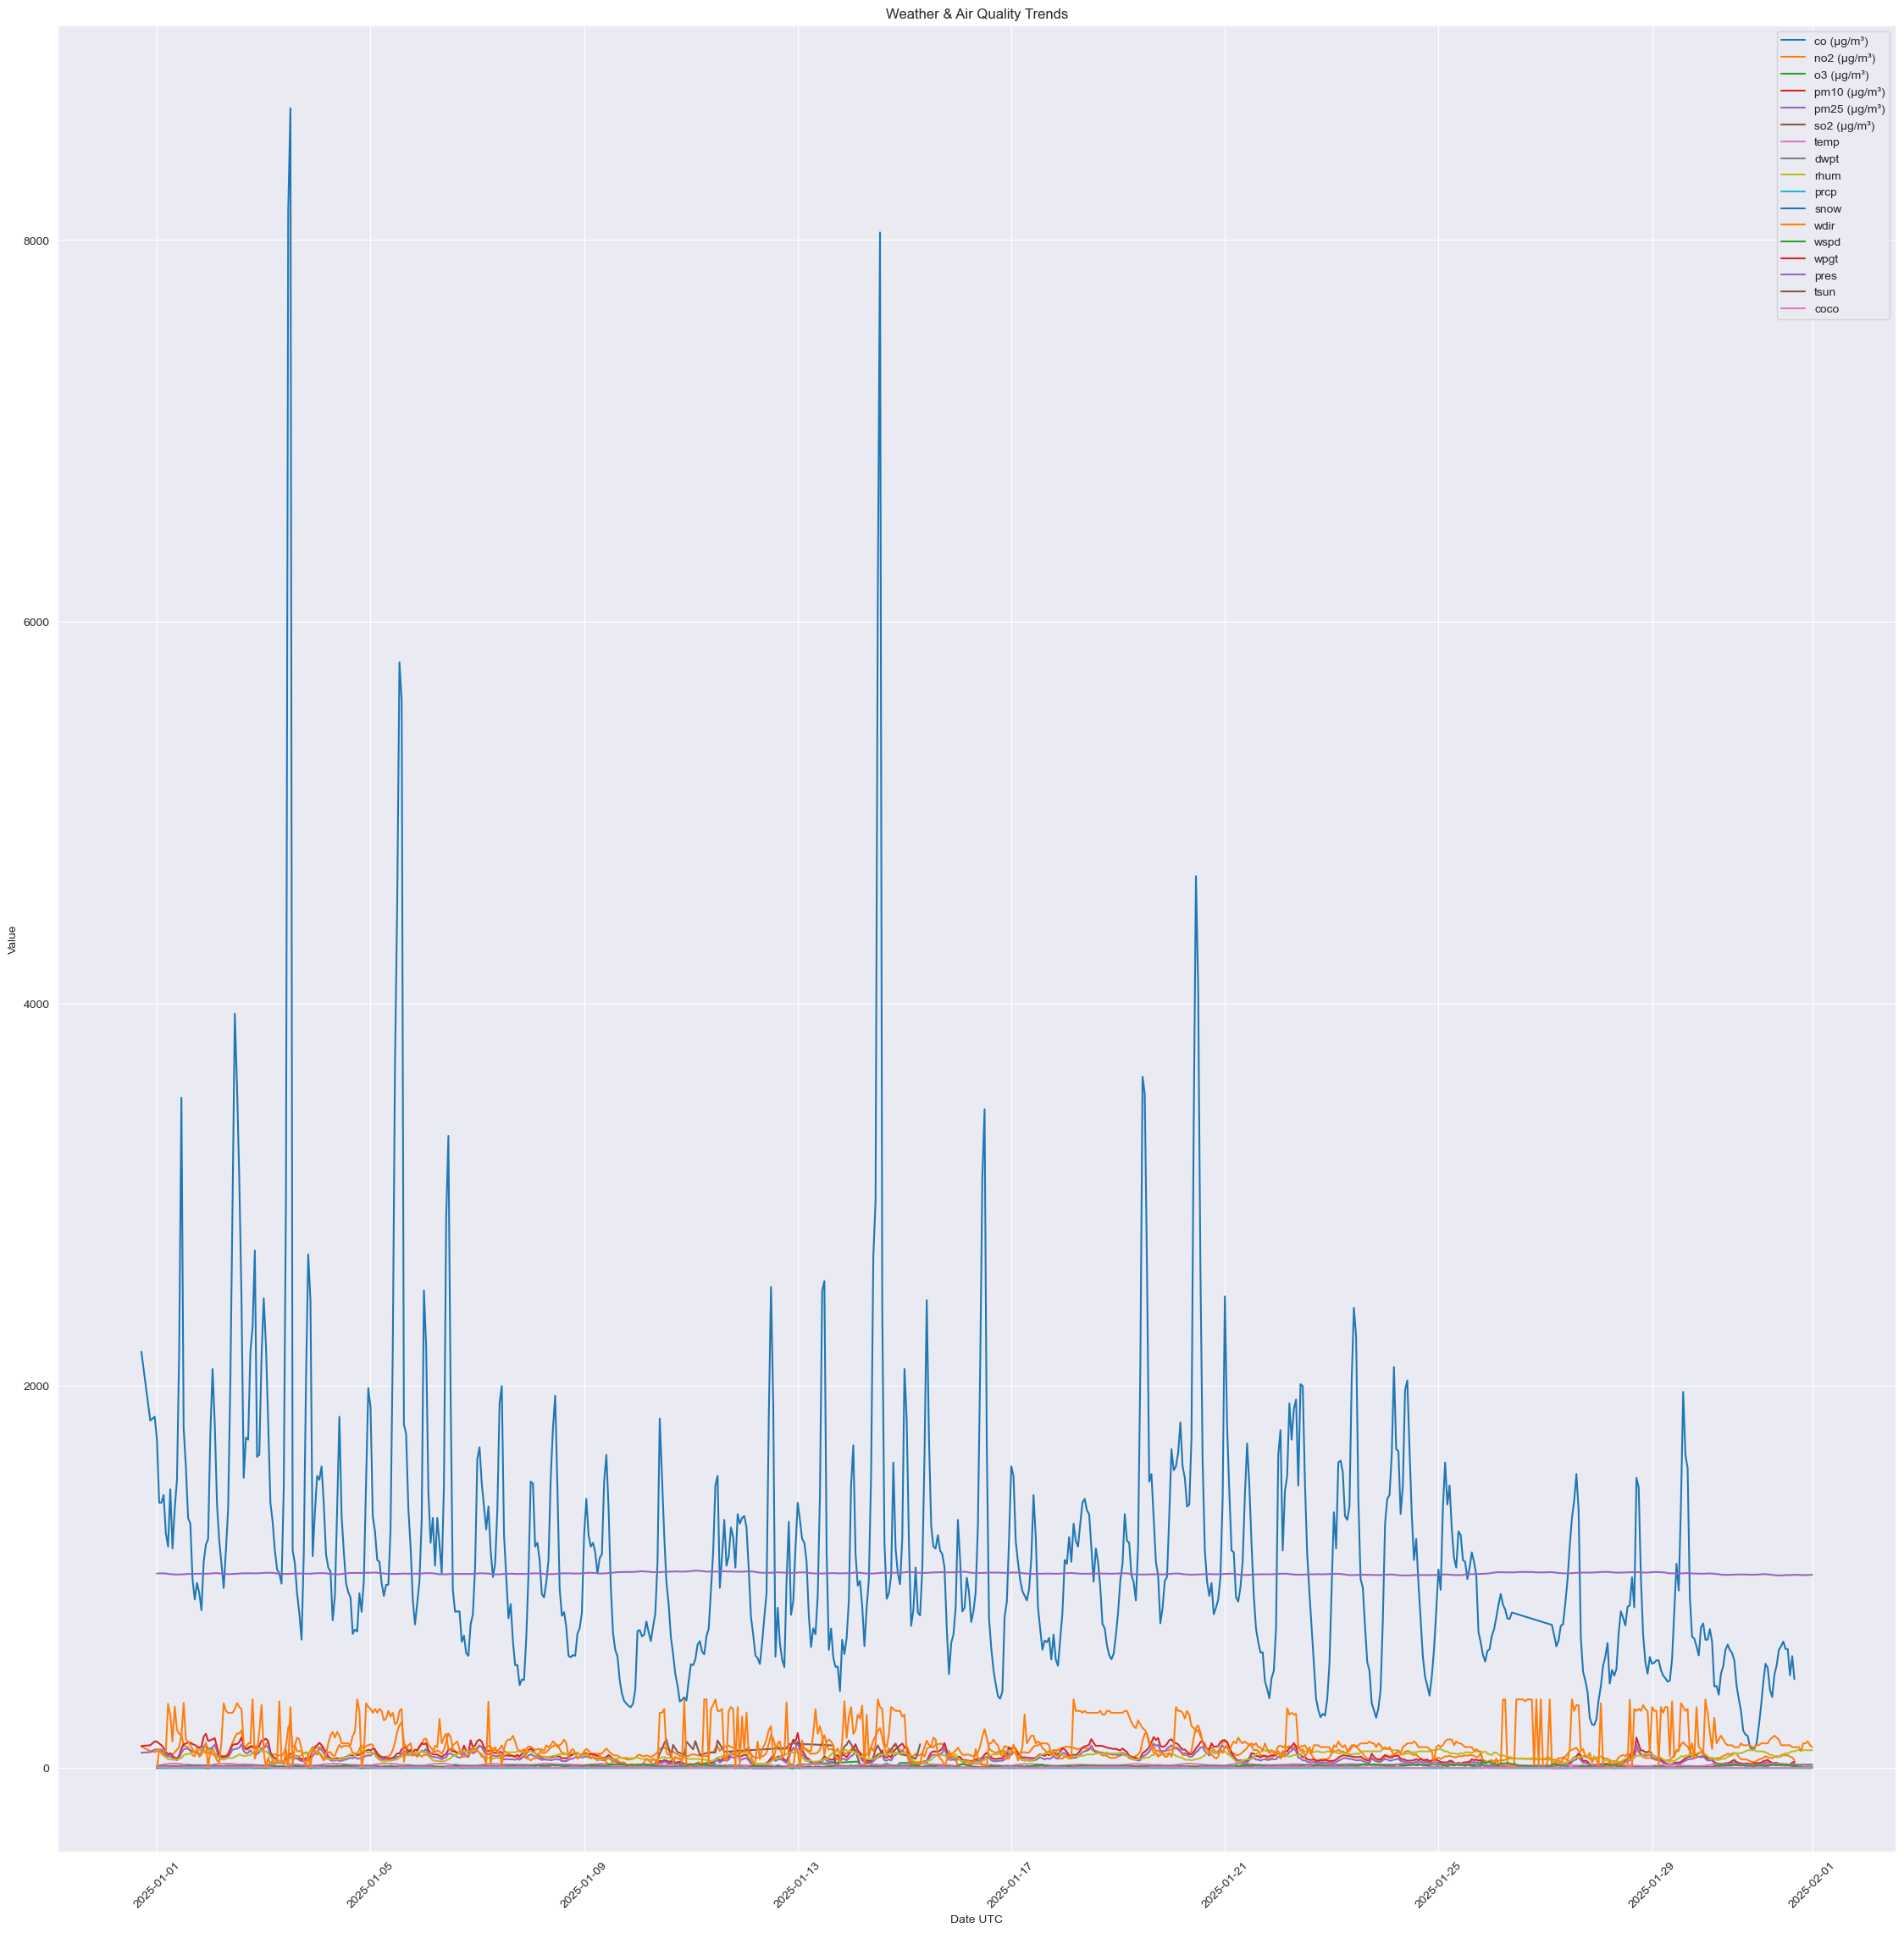

In [188]:
# Vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

# Loại bỏ cột "Date UTC" để lấy danh sách thông số
parameters = [col for col in merged_df.columns if col != "Date UTC"]

# Vẽ biểu đồ
plt.figure(figsize=(28, 28))

# Vẽ tất cả thông số có trong dataset
for param in parameters:
    try:
        sns.lineplot(x="Date UTC", y=param, data=merged_df, label=param)
    except Exception as e:
        print(f"⚠️ Không thể vẽ {param}: {e}")

# Tùy chỉnh biểu đồ
plt.xlabel("Date UTC")
plt.ylabel("Value")
plt.title("Weather & Air Quality Trends")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()